In [62]:
#for reading files
import glob
import tifffile

#math computation and data organization
import numpy as np
import math
import scipy
from scipy.ndimage import binary_erosion, binary_fill_holes
from scipy import optimize
from scipy.optimize import curve_fit
import pandas as pd

# For loading bars
from tqdm.notebook import tqdm as tqdm

#For image plotting
import skimage.io

#For identifying aster center
from skimage.filters import threshold_otsu, gaussian, threshold_mean
from skimage.measure import regionprops
import cv2

#for fitting
from lmfit import minimize, Parameters, fit_report

#for image registration
from skimage.registration import phase_cross_correlation
import os

#Matplotlib plotting packages
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import patches
from matplotlib import gridspec

import seaborn as sns
sns.set_context("poster")
sns.set_style("ticks")

#for saving data
import csv
import h5py

#custom analysis packages
import aster_packages as ap #### commented out 20241114 since lucida fonts are not installed...

# Thing to enable lovely parallelization
import concurrent.futures

# Enable repeat from itertools for parallel
import itertools

#time elements for testing runtimes and using todays date
import time
from datetime import datetime

In [106]:
def grab_dark_avg(file_path_dark):
    """
    Imports a dark image.
 
    Parameters:
    file_path_dark (string): Data path for a dark image.
    
    Returns:
    dark_avg (numpy.ndarray): Dark image as a 2D array.
    """
    dark_files = np.sort(glob.glob(file_path_dark))
    dark_ims = ap.file_to_image(dark_files)
    dark_avg = np.average(dark_ims, axis=0)
    return dark_avg

In [103]:
def backSubtract(arrs, dark_avg):
    """
    Subtracts camera dark noise from images
    
    Parameters:
    arrs (lsit): list of 3D numpy.ndarray's containing aster images where each array is from a different fluorescent channel.
    dark_avg (numpy.ndarray): 2D array image taken with the camera shutter closed of shape (m, n)
    
    Returns:
    (list): list of 3D numpy.ndarray's with dark camera noise subtracted.
    """
    return [arr-dark_avg for arr in arrs] # save processed images

In [104]:
def fit_bivariate_quadratic_anyShape(vals, coord):
    """
    Fits a bivariate quadratic polynomial to the intensity values of a grayscale image.
    
    Parameters:
    binary_im (numpy.ndarray): Grayscale image of shape (M, N).
    
    Returns:
    coefficients (numpy.ndarray): Coefficients of the fitted polynomial [a00, a10, a01, a20, a11, a02].
    """
    # Flatten the matrices for the least squares fitting
    I_flat = coord[0]
    J_flat = coord[1]
    Z_flat = vals

    # Create the design matrix for the polynomial terms
    A = np.vstack([I_flat**2, J_flat**2, I_flat*J_flat, I_flat, J_flat, np.ones_like(I_flat)]).T

    # Solve for the coefficients using least squares
    coefficients, _, _, _ = np.linalg.lstsq(A, Z_flat, rcond=None)

    return coefficients

def evaluateBivPoly_anyShape(vals,coord):
    """ Given coordinates, this function returns the best-fit bivariate polynomial for image. """
    coefficients=fit_bivariate_quadratic_anyShape(vals, coord);
    I, J = coord[0], coord[1]
    Z_fitted = (coefficients[0] * I**2 + coefficients[1] * J**2 +
            coefficients[2] * I * J + coefficients[3] * I +
            coefficients[4] * J + coefficients[5])
    return Z_fitted

In [167]:
def norm_unev(arrs_sub, mask_coords, allmask_coords):
    """
    Corrects uneven illumination by fitting an image to a bivariate polynomial, normalizing the polynomial, and dividing an array of images by this normalized matrix.
    
    Parameters:
    arrs_sub (list): Dark image subtracted list of image arrays.
    mask_coords (length 2 tuple): illumination mask coordinates (for one image)
    allmask_coords (slice): slice containing all the illumination coordinates with an extra dimension to account for all timepoints
    
    Returns:
    arr_ev (list): list of image arrays after the evening process.
    """
    #norm_mats = []
    arrs_ev = []
    
    for arr in arrs_sub:
        #compute the bivariate filter
        biv_filt = np.zeros_like(arr[0])
        biv_filt[mask_coords] = evaluateBivPoly_anyShape(arr[0, :, :][mask_coords], mask_coords)
        #norm_mats.append(norm_mat)
        
        #scale the normalization matrix such that the average value after multiplication is the same as the bs image
        scalar = np.mean(arr[0][mask_coords])/np.mean(arr[0][mask_coords]/biv_filt[mask_coords])
        norm_mat = scalar/biv_filt
        print(norm_mat[mask_coords].shape)
        
        arrs_ev_temp = np.zeros_like(arr)
        # print(arr[allmask_coords].shape)
        # print(norm_mat[mask_coords].shape)
        arrs_ev_temp[allmask_coords]=arr[allmask_coords]*norm_mat[mask_coords]
        
        arrs_ev.append(arrs_ev_temp)
        
    return arrs_ev

In [32]:
directories

array(['../../data/atp_cal/ATP_Calibration_Dec2024/10X_20sInterval_1000uMATP_2.8uMA81D_1',
       '../../data/atp_cal/ATP_Calibration_Dec2024/10X_20sInterval_0uMATP_2.8uMA81D_2',
       '../../data/atp_cal/ATP_Calibration_Dec2024/10X_20sInterval_800uMATP_2.8uMA81D_1',
       '../../data/atp_cal/ATP_Calibration_Dec2024/10X_20sInterval_3000uMATP_2.8uMA81D_1',
       '../../data/atp_cal/ATP_Calibration_Dec2024/10X_20sInterval_500uMATP_2.8uMA81D_1',
       '../../data/atp_cal/ATP_Calibration_Dec2024/10X_20sInterval_100uMATP_2.8uMA81D_1',
       '../../data/atp_cal/ATP_Calibration_Dec2024/10X_20sInterval_50uMATP_2.8uMA81D_1',
       '../../data/atp_cal/ATP_Calibration_Dec2024/10X_20sInterval_5000uMATP_2.8uMA81D_1',
       '../../data/atp_cal/ATP_Calibration_Dec2024/10X_20sInterval_30uMATP_2.8uMA81D_1',
       '../../data/atp_cal/ATP_Calibration_Dec2024/10X_20sInterval_1420uMATP_2.8uMA81D_2',
       '../../data/atp_cal/ATP_Calibration_Dec2024/10X_20sInterval_70uMATP_2.8uMA81D_1'],
      dtyp

In [9]:
srcdir = '../../data/atp_cal/ATP_Calibration_Dec2024/'

#extract all the ATP values
directories=glob.glob(srcdir+'*')

In [10]:
directories

['../../data/atp_cal/ATP_Calibration_Dec2024/10X_20sInterval_1000uMATP_2.8uMA81D_1',
 '../../data/atp_cal/ATP_Calibration_Dec2024/10X_20sInterval_0uMATP_2.8uMA81D_2',
 '../../data/atp_cal/ATP_Calibration_Dec2024/10X_20sInterval_800uMATP_2.8uMA81D_1',
 '../../data/atp_cal/ATP_Calibration_Dec2024/10X_20sInterval_3000uMATP_2.8uMA81D_1',
 '../../data/atp_cal/ATP_Calibration_Dec2024/10X_20sInterval_500uMATP_2.8uMA81D_1',
 '../../data/atp_cal/ATP_Calibration_Dec2024/10X_20sInterval_100uMATP_2.8uMA81D_1',
 '../../data/atp_cal/ATP_Calibration_Dec2024/10X_20sInterval_50uMATP_2.8uMA81D_1',
 '../../data/atp_cal/ATP_Calibration_Dec2024/10X_20sInterval_5000uMATP_2.8uMA81D_1',
 '../../data/atp_cal/ATP_Calibration_Dec2024/10X_20sInterval_30uMATP_2.8uMA81D_1',
 '../../data/atp_cal/ATP_Calibration_Dec2024/10X_20sInterval_1420uMATP_2.8uMA81D_2',
 '../../data/atp_cal/ATP_Calibration_Dec2024/10X_20sInterval_70uMATP_2.8uMA81D_1']

In [ ]:
0uM:{[rep1_channel1_intens, rep2_channel1_intens],
     [rep2_channel1_intens, rep2_channel2_intens]}

In [14]:
subDirExample=glob.glob(directories[0]+'/*.tif')
subDirExample

['../../data/atp_cal/ATP_Calibration_Dec2024/10X_20sInterval_1000uMATP_2.8uMA81D_1/10X_20sInterval_1000uMATP_2.8uMA81D_1_MMStack_Pos0.ome.tif',
 '../../data/atp_cal/ATP_Calibration_Dec2024/10X_20sInterval_1000uMATP_2.8uMA81D_1/10X_20sInterval_1000uMATP_2.8uMA81D_1_MMStack_Pos1.ome.tif',
 '../../data/atp_cal/ATP_Calibration_Dec2024/10X_20sInterval_1000uMATP_2.8uMA81D_1/10X_20sInterval_1000uMATP_2.8uMA81D_1_MMStack_Pos2.ome.tif']

In [24]:
def parse_ome(file, channel_list=['405', '480']):
    """
    Extracts image arrays from an ome.tif file.
    
    Parameters:
    file (string): Data file path.
    channel_list (list of strings): Names of fluorescent channels taken in this dataset
    
    Returns:
    (list): List of images (as 3D numpy.ndarrays) for each fluorescent channel with shape (# images, m, n).
    """
    
    images = []
    # Open and read the OME-TIFF file
    with tifffile.TiffFile(file) as tif:

        for i, page in enumerate(tif.pages):
            image_data = page.asarray()
            images.append(image_data)

        # Access the OME metadata if needed
        ome_metadata = tif.ome_metadata
        
    #how the pages are stored in ome
    ch1 = images[0::2] #0 for first channel : : 2 for 2 total channels
    ch2 = images[1::2] #1 for first channel : : 2 for 2 total channels
    
    return [np.array(ch1), np.array(ch2)]

In [25]:
blah = parse_ome('../../data/atp_cal/ATP_Calibration_Dec2024/10X_20sInterval_1000uMATP_2.8uMA81D_1/10X_20sInterval_1000uMATP_2.8uMA81D_1_MMStack_Pos2.ome.tif')


In [27]:
blah[1].shape

(25, 1200, 1920)

In [58]:
#Directory for calibration data that has many timepoints to assess photobleaching
srcdir = '../../data/atp_cal/ATP_Calibration_Dec2024/'

#extract all the ATP values
directories=np.array(glob.glob(srcdir+'*'))
ATPconcs = np.sort([int(x.split('20sInterval_')[1].split('uMATP')[0]) for x in directories])

crop = np.s_[300:900, 700:1300]

# hackish way of parsing subdirectories
results={}
for atp in ATPconcs:
    idx = np.where(['_'+str(atp)+'uMATP' in x for x in directories])[0][0]
    #results    
    subDir=glob.glob(directories[idx]+'/*.tif') # this gives a list of the numberOfPositions=three ome.tif names
    theseResults=[parse_ome(x) for x in subDir] # this is a list of length(numberOfPositions)
    results[atp]=theseResults
    
    print(atp)

0
30
50
70
100
500
800
1000
1420
3000
5000


In [61]:
channel0example=results[100][0][0]
channel0example.shape

(25, 1200, 1920)

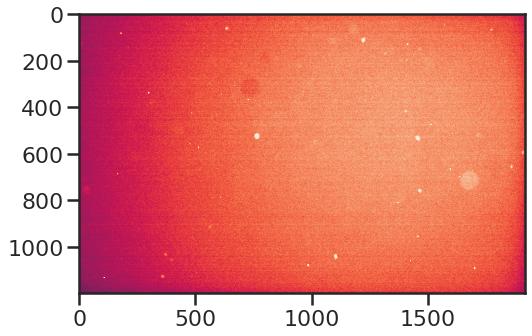

In [63]:
fig, ax = plt.subplots(figsize=(8,8))
plt.imshow(channel0example[0,:,:], vmax=np.percentile(channel0example[0,:,:], 99))

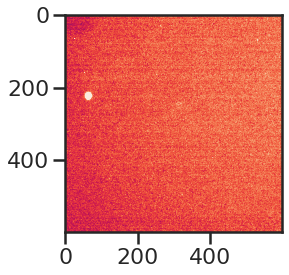

In [67]:
crop = np.s_[300:900, 700:1300]
plt.imshow(channel0example[0,:,:][crop], vmax=np.percentile(channel0example[0,:,:], 99))

In [69]:
### Hackish extraction dun dun dun
cropAcrossTimes = np.s_[:, 300:900, 700:1300]
summaryResults={}
for atp in ATPconcs:
    thisATPresult=results[atp]
    for pos in range(len(thisATPresult)):
        for channel in range(len(thisATPresult[pos])):
            summaryResults[(atp, pos, channel)]=np.mean(thisATPresult[pos][channel][cropAcrossTimes], axis=(1,2))

Text(0.5, 0, 'time')

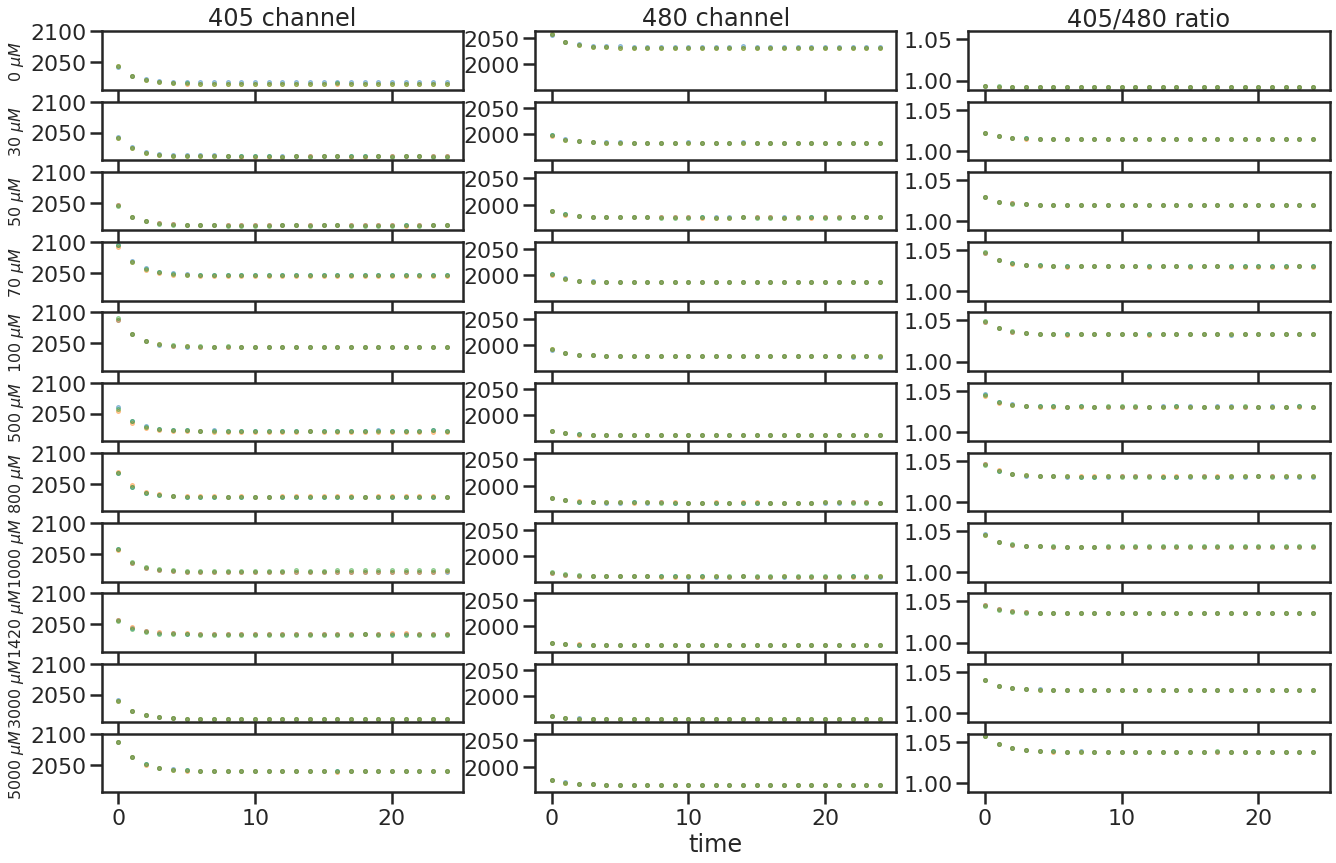

In [99]:
fig, ax = plt.subplots(len(ATPconcs),3, figsize=(22,14), sharey='col')
for a, atp in enumerate(ATPconcs):
    ax[a][0].set_ylabel(str(atp)+r' $\mu M$', fontsize=16)
    for pos in range(3):
        for col in range(3):
            if col<2:
                ax[a][col].plot(summaryResults[(atp, pos, col)], 'o', ms=4, alpha=0.4) 
            else:
                ax[a][col].plot(summaryResults[(atp, pos, 0)]/summaryResults[(atp, pos, 1)], 'o', ms=4, alpha=0.4)
            # ax[a][col].set_yscale('log')
ax[0][0].set_title('405 channel')
ax[0][1].set_title('480 channel')
ax[0][2].set_title('405/480 ratio')
ax[-1][1].set_xlabel('time')

### derivative

Text(0.5, 0, 'time')

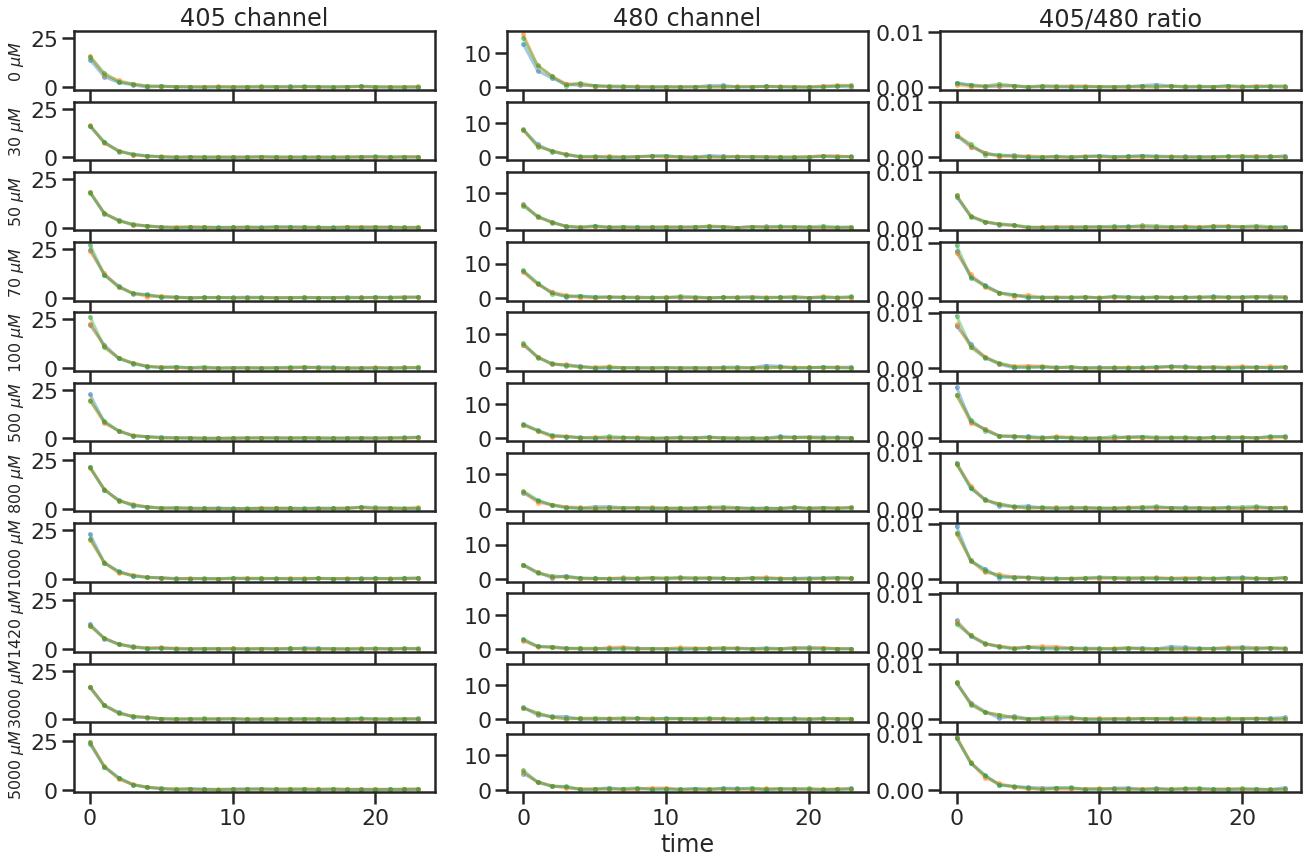

In [102]:
fig, ax = plt.subplots(len(ATPconcs),3, figsize=(22,14), sharey='col')
for a, atp in enumerate(ATPconcs):
    ax[a][0].set_ylabel(str(atp)+r' $\mu M$', fontsize=16)
    for pos in range(3):
        for col in range(3):
            if col<2:
                ax[a][col].plot(np.abs(np.diff(summaryResults[(atp, pos, col)])), 'o-', ms=4, alpha=0.4) 
            else:
                ax[a][col].plot(np.abs(np.diff(summaryResults[(atp, pos, 0)]/summaryResults[(atp, pos, 1)])), 'o-', ms=4, alpha=0.4)
            # ax[a][col].set_yscale('log')
ax[0][0].set_title('405 channel')
ax[0][1].set_title('480 channel')
ax[0][2].set_title('405/480 ratio')
ax[-1][1].set_xlabel('time')

array([[<Axes: title={'center': '405 channel'}, ylabel='0 $\\mu M$'>,
        <Axes: title={'center': '480 channel'}>,
        <Axes: title={'center': '405/480 ratio'}>],
       [<Axes: ylabel='30 $\\mu M$'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='50 $\\mu M$'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='70 $\\mu M$'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='100 $\\mu M$'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='500 $\\mu M$'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='800 $\\mu M$'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='1000 $\\mu M$'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='1420 $\\mu M$'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='3000 $\\mu M$'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='5000 $\\mu M$'>, <Axes: xlabel='time'>, <Axes: >]],
      dtype=object)

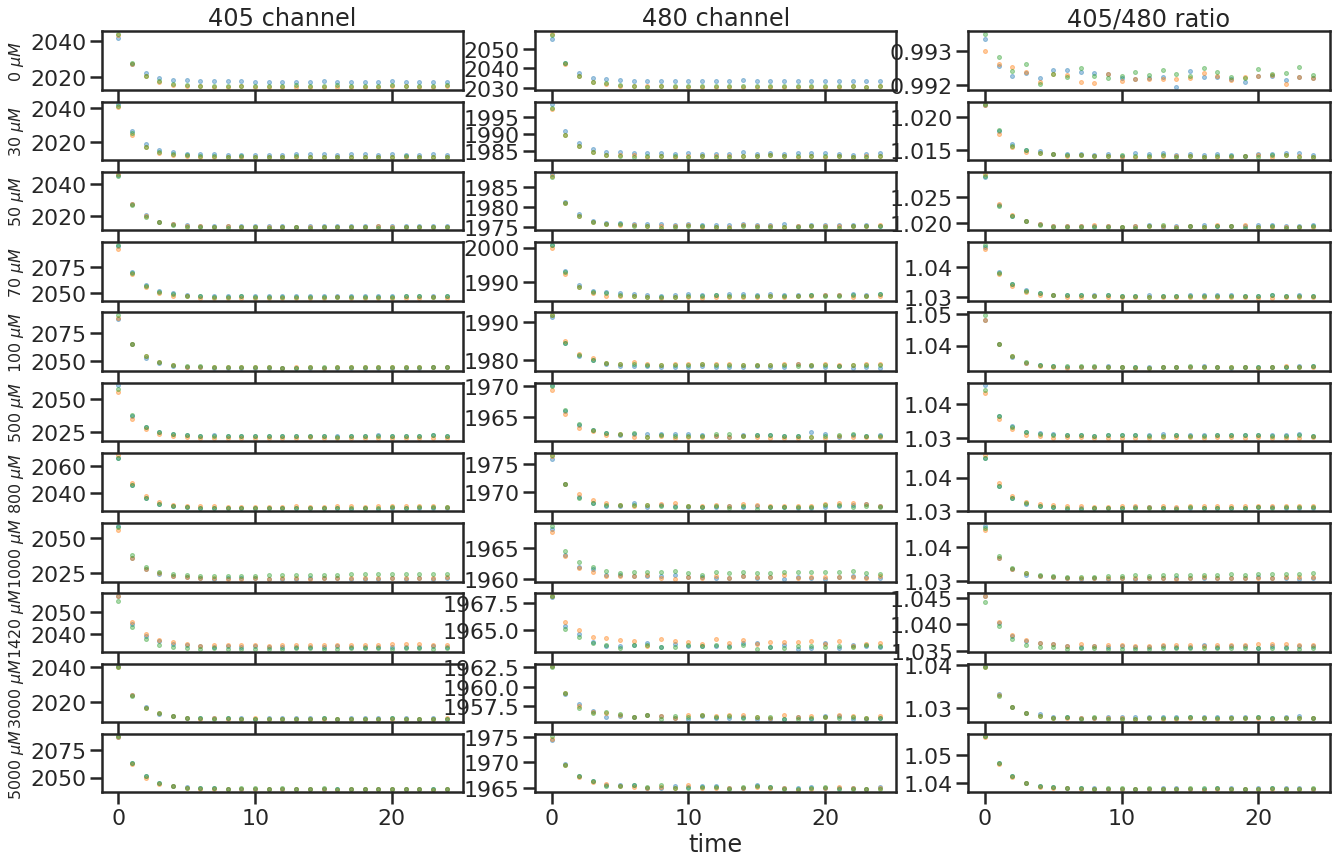

In [93]:
fig, ax = plt.subplots(len(ATPconcs),3, figsize=(22,14))
for a, atp in enumerate(ATPconcs):
    ax[a][0].set_ylabel(str(atp)+r' $\mu M$', fontsize=16)
    for pos in range(3):
        for col in range(3):
            if col<2:
                ax[a][col].plot(summaryResults[(atp, pos, col)], 'o', ms=4, alpha=0.4) 
            else:
                ax[a][col].plot(summaryResults[(atp, pos, 0)]/summaryResults[(atp, pos, 1)], 'o', ms=4, alpha=0.4)

ax[0][0].set_title('405 channel')
ax[0][1].set_title('480 channel')
ax[0][2].set_title('405/480 ratio')
ax[-1][1].set_xlabel('time')

Text(0.5, 0, 'time')

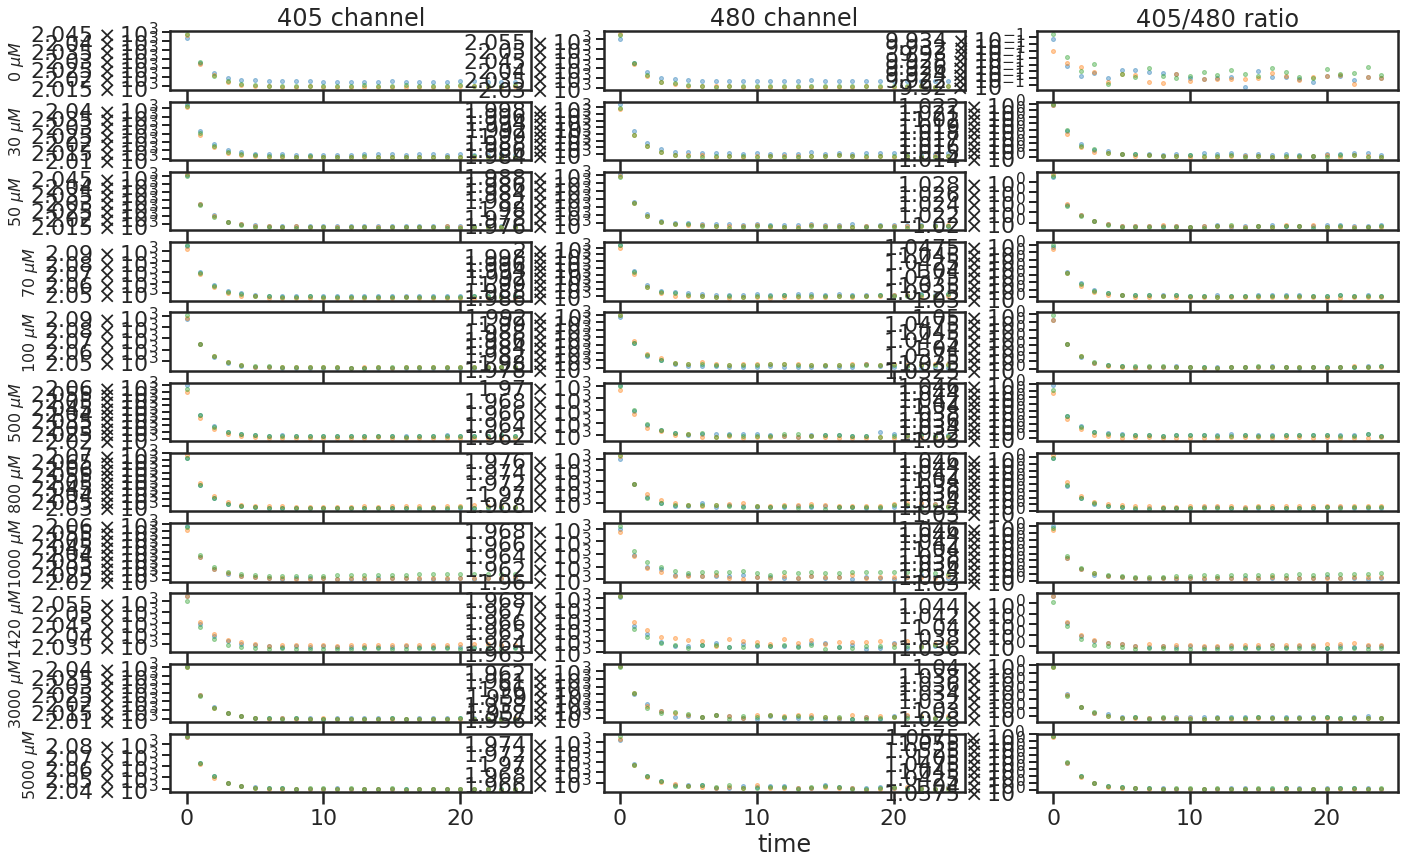

In [96]:
fig, ax = plt.subplots(len(ATPconcs),3, figsize=(22,14))
for a, atp in enumerate(ATPconcs):
    ax[a][0].set_ylabel(str(atp)+r' $\mu M$', fontsize=16)
    for pos in range(3):
        for col in range(3):
            if col<2:
                ax[a][col].plot(summaryResults[(atp, pos, col)], 'o', ms=4, alpha=0.4) 
            else:
                ax[a][col].plot(summaryResults[(atp, pos, 0)]/summaryResults[(atp, pos, 1)], 'o', ms=4, alpha=0.4)
            ax[a][col].set_yscale('log')

ax[0][0].set_title('405 channel')
ax[0][1].set_title('480 channel')
ax[0][2].set_title('405/480 ratio')
ax[-1][1].set_xlabel('time')

In [116]:
mask = np.zeros_like(results[0][0][0][0])
mask[crop] = 1
crop_coords = np.where(mask==1)
mask = np.zeros_like(results[0][0][0])
mask[cropAcrossTimes] = 1
allcrop_coords = np.where(mask==1)

In [115]:
results[0][0][0].shape

(25, 1200, 1920)

# Do it with normalization

In [149]:
mask = np.zeros_like(results[0][0][0])
print(np.sum(mask>0))
mask[cropAcrossTimes] = 1
print(np.sum(mask>0))
allcrop_coords = np.where(mask==1)

0
9000000


In [152]:
crop_coords

(array([300, 300, 300, ..., 899, 899, 899]),
 array([ 700,  701,  702, ..., 1297, 1298, 1299]))

In [151]:
allcrop_coords


(array([ 0,  0,  0, ..., 24, 24, 24]),
 array([300, 300, 300, ..., 899, 899, 899]),
 array([ 700,  701,  702, ..., 1297, 1298, 1299]))

In [168]:
file_path_dark = '../../data/dark_ims/2021-01-13_nocamera_dark_1/*Pos*/*tif*'
dark_avg = grab_dark_avg(file_path_dark)
crop = np.s_[300:900, 700:1300]
cropAcrossTimes = np.s_[:, 300:900, 700:1300]

mask = np.zeros_like(results[0][0][0][0])
mask[crop] = 1
crop_coords = np.where(mask==1)

mask = np.zeros_like(results[0][0][0])
mask[cropAcrossTimes] = 1
allcrop_coords = np.where(mask==1)


normedResults={}
for atp in ATPconcs[0:1]:
    for pos in range(len(results[atp])):
        arrs = results[atp][pos]
        arrs_sub = backSubtract(arrs, dark_avg)
        arrs_norm=norm_unev(arrs_sub, crop_coords, cropAcrossTimes)
        #ratios = arrs_norm[0][allcrop_coords]/arrs_norm[1][allcrop_coords]

/tmp/ipykernel_440503/3365823086.py:24: RuntimeWarning: divide by zero encountered in divide
  norm_mat = scalar/biv_filt


(360000,)


ValueError: operands could not be broadcast together with shapes (25,600,600) (360000,) 

In [174]:
results[0][0][0].shape

(25, 1200, 1920)

In [173]:
results[0][0][0][0].shape

(1200, 1920)

In [166]:
arrs_sub[0][cropAcrossTimes].shape

(25, 600, 600)

In [169]:
len(arrs_sub)

2

In [170]:
arrs_sub[0].shape

(25, 1200, 1920)

In [171]:
arrs_sub[0][crop_coords]

IndexError: index 300 is out of bounds for axis 0 with size 25

In [172]:
crop_coords

(array([300, 300, 300, ..., 899, 899, 899]),
 array([ 700,  701,  702, ..., 1297, 1298, 1299]))

In [161]:
25*600*600

9000000

In [141]:
allcrop_coords[0].shape, crop_coords[0].shape

((9000000,), (360000,))

In [127]:
arrs_sub[1][allcrop_coords]

array([168.        , 144.        , 114.66666667, ..., 106.66666667,
       138.66666667, 117.33333333])